In [2]:
import os

if "src" not in os.listdir():
    os.chdir("../")

In [ ]:
import gc

import pandas as pd
from tqdm import tqdm

tqdm.pandas()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
path_files = "./data/interim/split_9111_dataset"

res = []
for name_file in tqdm(os.listdir(path_files)):
    res.append(pd.read_parquet(os.path.join(path_files, name_file)))

df = pd.concat(res)

del res
gc.collect()

100%|██████████| 12/12 [05:54<00:00, 29.55s/it]


0

In [5]:
# запись из-за который возникала ошибка
df_bad_record = pd.DataFrame(
    {
        "id": 18536837,
        "title": "Как мне получить субсидии на ком. платежи, если я ухаживаю за пожилым человеком старше 80 лет.",
        "description": "Как мне получить субсидии на ком. платежи, если я ухаживаю за пожилым человеком старше 80 лет.",
        "answers": [
            [
                {
                    "user_name": "Парфенов В.Н.",
                    "status": "Юрист",
                    "rating": 4.6,
                    "text": "К сожалению, то что вы ухаживаете за пожилым человеком старше 80 лет.-не является основанием для получения субсидии на оплату коммунальных услуг стст 153-155 ЖК РФ.",
                }
            ]
        ],
    }
)
df = pd.concat([df, df_bad_record])

In [6]:
df.head(5)

,id,title,description,answers
0,16420931,Необходимость работы сверх установленного граф...,"Я работы в мосметро в ПТБ, и график у меня сме...","[{'user_name': 'Чередниченко В.А.', 'status': ..."
1,16420932,"Хочу сестру лишить родительских прав, но не хо...","Хочу сестру лешить родительских прав, но не х...","[{'user_name': 'Тома А. В.', 'status': 'Юрист'..."
2,16420933,Можно ли при вступлении в наследство у нотариу...,Можно ли при вступлении в наследство у нотари...,"[{'user_name': 'Елисеева Е. Е.', 'status': 'Юр..."
3,16420940,Вопрос о льготах на оплату детского сада для д...,У меня такой вопрос у меня 2 детей. У меня был...,"[{'user_name': 'Ростовцев В. В.', 'status': 'Ю..."
4,16420941,Будут ли приходить штрафы с камер видео-фото н...,Если выписали протокол за тонировку на машину...,"[{'user_name': 'Попов П. Е.', 'status': 'Юрист..."


In [7]:
print(df["description"].sample().to_list()[0])

Я являюсь собственником квартиры, год назад я купила квартиру с прописанным совершеннолетним человеком, он временно работает живёт в Москве приехать выписаться не может, я хочу выписать его через суд, его обяжет ли суд явиться? Если он не может приехать. Или ему проще самому выписаться в никуда? Заплатив позже штраф, Заранее спасибо за ответ.


In [8]:
df["description"].iloc[0]

'Я работы в мосметро в ПТБ, и график у меня сменный 12 часов! В месяц выходит 186 часов и они не вмещаются в во все рабочие дни и ставят нам не 12 часов а 13 часов а если не хочешь дорабатывать, выходи в выходной день! Скажите, кто прав и законно ли все это? Потому как в трудовом договоре  честно написано-день 12, ночь 12, отсыпной и выходной! Спасибо.'

### Анализ датасета

In [9]:
print(f"Всего вопросов: {df.shape[0]:,}")

Всего вопросов: 11,292,803


Собираем статистику по вопросам и ответам:
- сколько и кто отвечал
- распределение рейтинга


In [10]:
counter_expert = []
counter_rating = []
counter_len_chat = []
author_in_chat = []


def stat(answers):
    answers = list(answers)
    len_answers = len(answers)

    counter_len_chat.append(len_answers)
    try:
        counter_expert.extend([i["status"] for i in answers])
        counter_rating.extend([i["rating"] for i in answers])
        for i in answers:
            if i["status"] == "Автор вопроса":
                author_in_chat.append(True)
                break
        else:
            author_in_chat.append(False)
    except:
        print(answers)

In [11]:
for i in tqdm(df["answers"].to_list()):
    stat(i)

100%|██████████| 11292803/11292803 [00:33<00:00, 340435.44it/s]


In [12]:
counter_len_chat_series = pd.Series(
    [i if i in [1, 2, 3, 4, 5] else -1 for i in counter_len_chat]
)

# показываем кол-во сообщений под каждым чатом
counter_len_chat_series.value_counts(normalize=True)

 1    0.581362
 2    0.214937
 3    0.094587
 4    0.044428
-1    0.040818
 5    0.023868
Name: proportion, dtype: float64

In [13]:
author_in_chat_series = pd.Series(author_in_chat)

# показываем как часто авторы вопроса продолжали диалог
author_in_chat_series.value_counts(normalize=True)

False    0.916276
True     0.083724
Name: proportion, dtype: float64

In [14]:
def norm(answers, description):
    answers = list(answers)
    try:
        len_answ = len(answers)
        rating = answers[0]["rating"]
        text = answers[0]["text"]
        len_description = len(description)
        len_text = len(text)
    except:
        len_answ, rating, text, len_description, len_text = None, None, None, None, None
    return len_answ, rating, text, len_description, len_text

In [15]:
df["author_in_chat"] = author_in_chat
df["counter_len_chat"] = counter_len_chat
df["counter_len_chat_bins"] = counter_len_chat_series

In [16]:
df.head()

,id,title,description,answers,author_in_chat,counter_len_chat,counter_len_chat_bins
0,16420931,Необходимость работы сверх установленного граф...,"Я работы в мосметро в ПТБ, и график у меня сме...","[{'user_name': 'Чередниченко В.А.', 'status': ...",False,1,1
1,16420932,"Хочу сестру лишить родительских прав, но не хо...","Хочу сестру лешить родительских прав, но не х...","[{'user_name': 'Тома А. В.', 'status': 'Юрист'...",False,1,1
2,16420933,Можно ли при вступлении в наследство у нотариу...,Можно ли при вступлении в наследство у нотари...,"[{'user_name': 'Елисеева Е. Е.', 'status': 'Юр...",False,2,2
3,16420940,Вопрос о льготах на оплату детского сада для д...,У меня такой вопрос у меня 2 детей. У меня был...,"[{'user_name': 'Ростовцев В. В.', 'status': 'Ю...",False,3,3
4,16420941,Будут ли приходить штрафы с камер видео-фото н...,Если выписали протокол за тонировку на машину...,"[{'user_name': 'Попов П. Е.', 'status': 'Юрист...",True,2,2


In [17]:
# отбираем все вопросы под которыми не писал сам автор вопроса, то есть без диалога
df_not_dialog = df[(~df["author_in_chat"])]

In [18]:
print(f"Всего диалоговых вопросов было: {df.shape[0] - df_not_dialog.shape[0]:,}")
print(f"Без диалога: {df_not_dialog.shape[0]:,}")

Всего диалоговых вопросов было: 945,481
Без диалога: 10,347,322


In [19]:
df_not_dialog["answers"].iloc[0][0]

{'user_name': 'Чередниченко В.А.',
 'status': 'Адвокат',
 'rating': 3.8,
 'text': 'Полагаю, что незаконно, но для более конкретного ответа нужно смотреть ваши локальные внутренние документы организации, а также ваш трудовой договор. Как вариант, вы можете обратиться с жалобой в трудовую инспекцию, чтобы провела документальную проверку. Но это конфликт с работодателем, так что нужно быть готовым к любым последствиям.'}

In [20]:
def func(answers):
    """
    Выделяем ответ юриста с максимальным рейтингом. 
    Если рейтинги одинаковые, то будет выбран первый ответ
     """
    max_index = 0
    max_rating = 0
    for index, i in enumerate(answers):
        if max_rating < i["rating"]:
            max_index = index
            max_rating = i["rating"]
    return answers[max_index], max_rating


df_not_dialog[["answers_max", "max_rating"]] = df_not_dialog.progress_apply(
    lambda x: func(x["answers"]), result_type="expand", axis=1
)

100%|██████████| 10347322/10347322 [06:45<00:00, 25527.62it/s]
/tmp/ipykernel_1414820/2025629751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_dialog[["answers_max", "max_rating"]] = df_not_dialog.progress_apply(
/tmp/ipykernel_1414820/2025629751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_dialog[["answers_max", "max_rating"]] = df_not_dialog.progress_apply(


In [21]:
df_not_dialog["max_rating"].describe()

count    1.034732e+07
mean     1.387905e+00
std      2.029759e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.200000e+00
max      8.600000e+00
Name: max_rating, dtype: float64

In [22]:
df_not_dialog.loc[df_not_dialog["max_rating"] > 0, "max_rating"].describe()

count    3.596666e+06
mean     3.992892e+00
std      1.204682e+00
min      1.100000e+00
25%      3.100000e+00
50%      3.900000e+00
75%      4.700000e+00
max      8.600000e+00
Name: max_rating, dtype: float64

<Axes: >

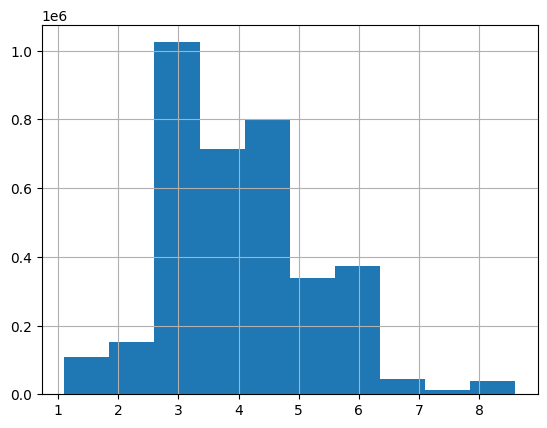

In [23]:
df_not_dialog.loc[df_not_dialog["max_rating"] > 0, "max_rating"].hist()

In [24]:
dialog_with_score = len(df_not_dialog.loc[df_not_dialog["max_rating"] > 0])
print(f"Кол-во диалогов с оценкой {dialog_with_score:,}")

Кол-во диалогов с оценкой 3,596,666


In [25]:
df_not_dialog.loc[df_not_dialog["max_rating"] > 0]

,id,title,description,answers,author_in_chat,counter_len_chat,counter_len_chat_bins,answers_max,max_rating
0,16420931,Необходимость работы сверх установленного граф...,"Я работы в мосметро в ПТБ, и график у меня сме...","[{'user_name': 'Чередниченко В.А.', 'status': ...",False,1,1,"{'user_name': 'Чередниченко В.А.', 'status': '...",3.8
2,16420933,Можно ли при вступлении в наследство у нотариу...,Можно ли при вступлении в наследство у нотари...,"[{'user_name': 'Елисеева Е. Е.', 'status': 'Юр...",False,2,2,"{'user_name': 'Гудкова Г.В.', 'status': 'Адвок...",1.5
5,16420942,"Куда и как обратиться осужденному, если ему за...",Осужденному при начислении заработной платы за...,"[{'user_name': 'Шулимов В. Г.', 'status': 'Юри...",False,1,1,"{'user_name': 'Шулимов В. Г.', 'status': 'Юрис...",4.4
6,16420944,Как получить почетную грамоту Министерства здр...,У меня есть грамота ФМБА России от 2018 г и ст...,"[{'user_name': 'Шулимов В. Г.', 'status': 'Юри...",False,1,1,"{'user_name': 'Шулимов В. Г.', 'status': 'Юрис...",4.4
12,16420957,Возможно ли переоформление мужа в программу ус...,Получили сертификат по программе устойчивое ра...,"[{'user_name': 'Чередниченко В.А.', 'status': ...",False,1,1,"{'user_name': 'Чередниченко В.А.', 'status': '...",3.8
...,...,...,...,...,...,...,...,...,...
999962,13948594,Применение ЗоЗПП в договоре об оказании услуг ...,Составлен договор об оказании услуг между физи...,"[{'user_name': 'Кузьминых С.В.', 'status': 'Юр...",False,2,3,"{'user_name': 'Панфилов А.Ф.', 'status': 'Адво...",4.9
999992,13948653,"Развод в семье, где один из супругов находится...","Здравствуйте, я хочу узнать если муж лежит в п...","[{'user_name': 'Байдина Д. Ю.', 'status': 'Юри...",False,3,2,"{'user_name': 'Панфилов А.Ф.', 'status': 'Адво...",4.9
999994,13948658,Можно ли подать новый иск к генеральному дирек...,Я физлицо. Было взыскание долга с ООО. \nСудеб...,"[{'user_name': 'DELETE', 'status': 'Юрист', 'r...",False,2,-1,"{'user_name': 'Булатова И.Д.', 'status': 'Юрис...",3.2
999995,13948659,Может ли директор школы перераспределить нагру...,Здравствуйте!\n Имеет ли право директор школы...,"[{'user_name': 'Кандакова А.В.', 'status': 'Юр...",False,11,1,"{'user_name': 'Каравайцева Е.А.', 'status': 'Ю...",5.9


### Вывод

Большая часть вопросов датасета 9111:
- без диалогов, тоесть автор вопроса не пишит на ответ юристов
- большая часть ответов дана юристами без рейтинга
- попадаются низкокачественные ответы

Считаю необходимым в дальнейшей работе использовать только те вопросы у которых нет диалога и на которые отвечал юрист с рейтингом